In [1]:
# Importación de las librerías necesarias

import math
import numpy as np
import pandas as pd
import seaborn as sns
import re
from data import toolbox_ML as tb
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from xgboost import XGBClassifier

In [2]:
# cargamos los datos

df = pd.read_csv("./data/wines_dataset.csv",sep="|")

<Axes: xlabel='class', ylabel='Count'>

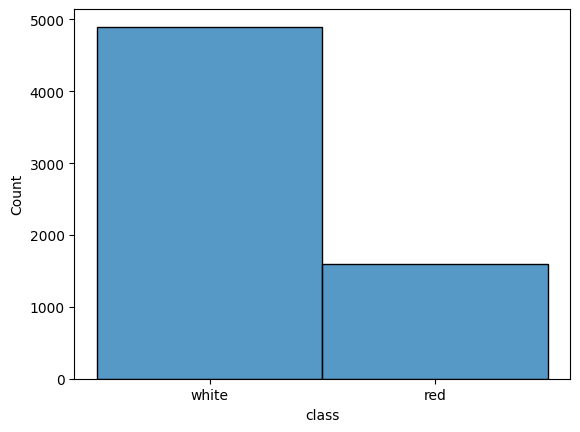

In [3]:
# Vemos distribución del target

target = "class"
sns.histplot(df,x=target)

In [4]:
# Estan descompensados, vamos a hacer un train_test split manteniendo la proporcion

X_train, X_test = train_test_split(df,test_size=0.2,random_state=42,stratify=df[target])

<Axes: xlabel='class', ylabel='Count'>

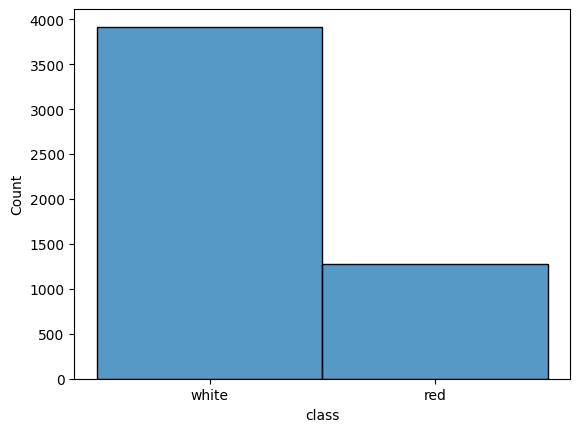

In [5]:
# Revisamos como están la distribución del target

target = "class"
sns.histplot(X_train,x=target)

In [6]:
# Revisamos la info del train

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5197 entries, 3369 to 5815
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5197 non-null   float64
 1   volatile acidity      5197 non-null   float64
 2   citric acid           5197 non-null   float64
 3   residual sugar        5197 non-null   float64
 4   chlorides             5197 non-null   float64
 5   free sulfur dioxide   5197 non-null   float64
 6   total sulfur dioxide  5197 non-null   float64
 7   density               5197 non-null   float64
 8   pH                    5197 non-null   float64
 9   sulphates             5197 non-null   float64
 10  alcohol               5197 non-null   float64
 11  quality               5197 non-null   int64  
 12  class                 5197 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 568.4+ KB


In [7]:
# Revisamos qué tenemos

tb.describe_df(X_train)

COL_N         fixed acidity volatile acidity citric acid residual sugar  \
DATA_TYPE           float64          float64     float64        float64   
MISSING (%)             0.0              0.0         0.0            0.0   
UNIQUE_VALUES           105              182          85            303   
CARDIN (%)             2.02              3.5        1.64           5.83   

COL_N         chlorides free sulfur dioxide total sulfur dioxide  density  \
DATA_TYPE       float64             float64              float64  float64   
MISSING (%)         0.0                 0.0                  0.0      0.0   
UNIQUE_VALUES       194                 128                  273      937   
CARDIN (%)         3.73                2.46                 5.25    18.03   

COL_N               pH sulphates  alcohol quality   class  
DATA_TYPE      float64   float64  float64   int64  object  
MISSING (%)        0.0       0.0      0.0     0.0     0.0  
UNIQUE_VALUES      105       106      105       7       2  
CARDIN (%)        2.02      2.04     2.02    0.13    0.04

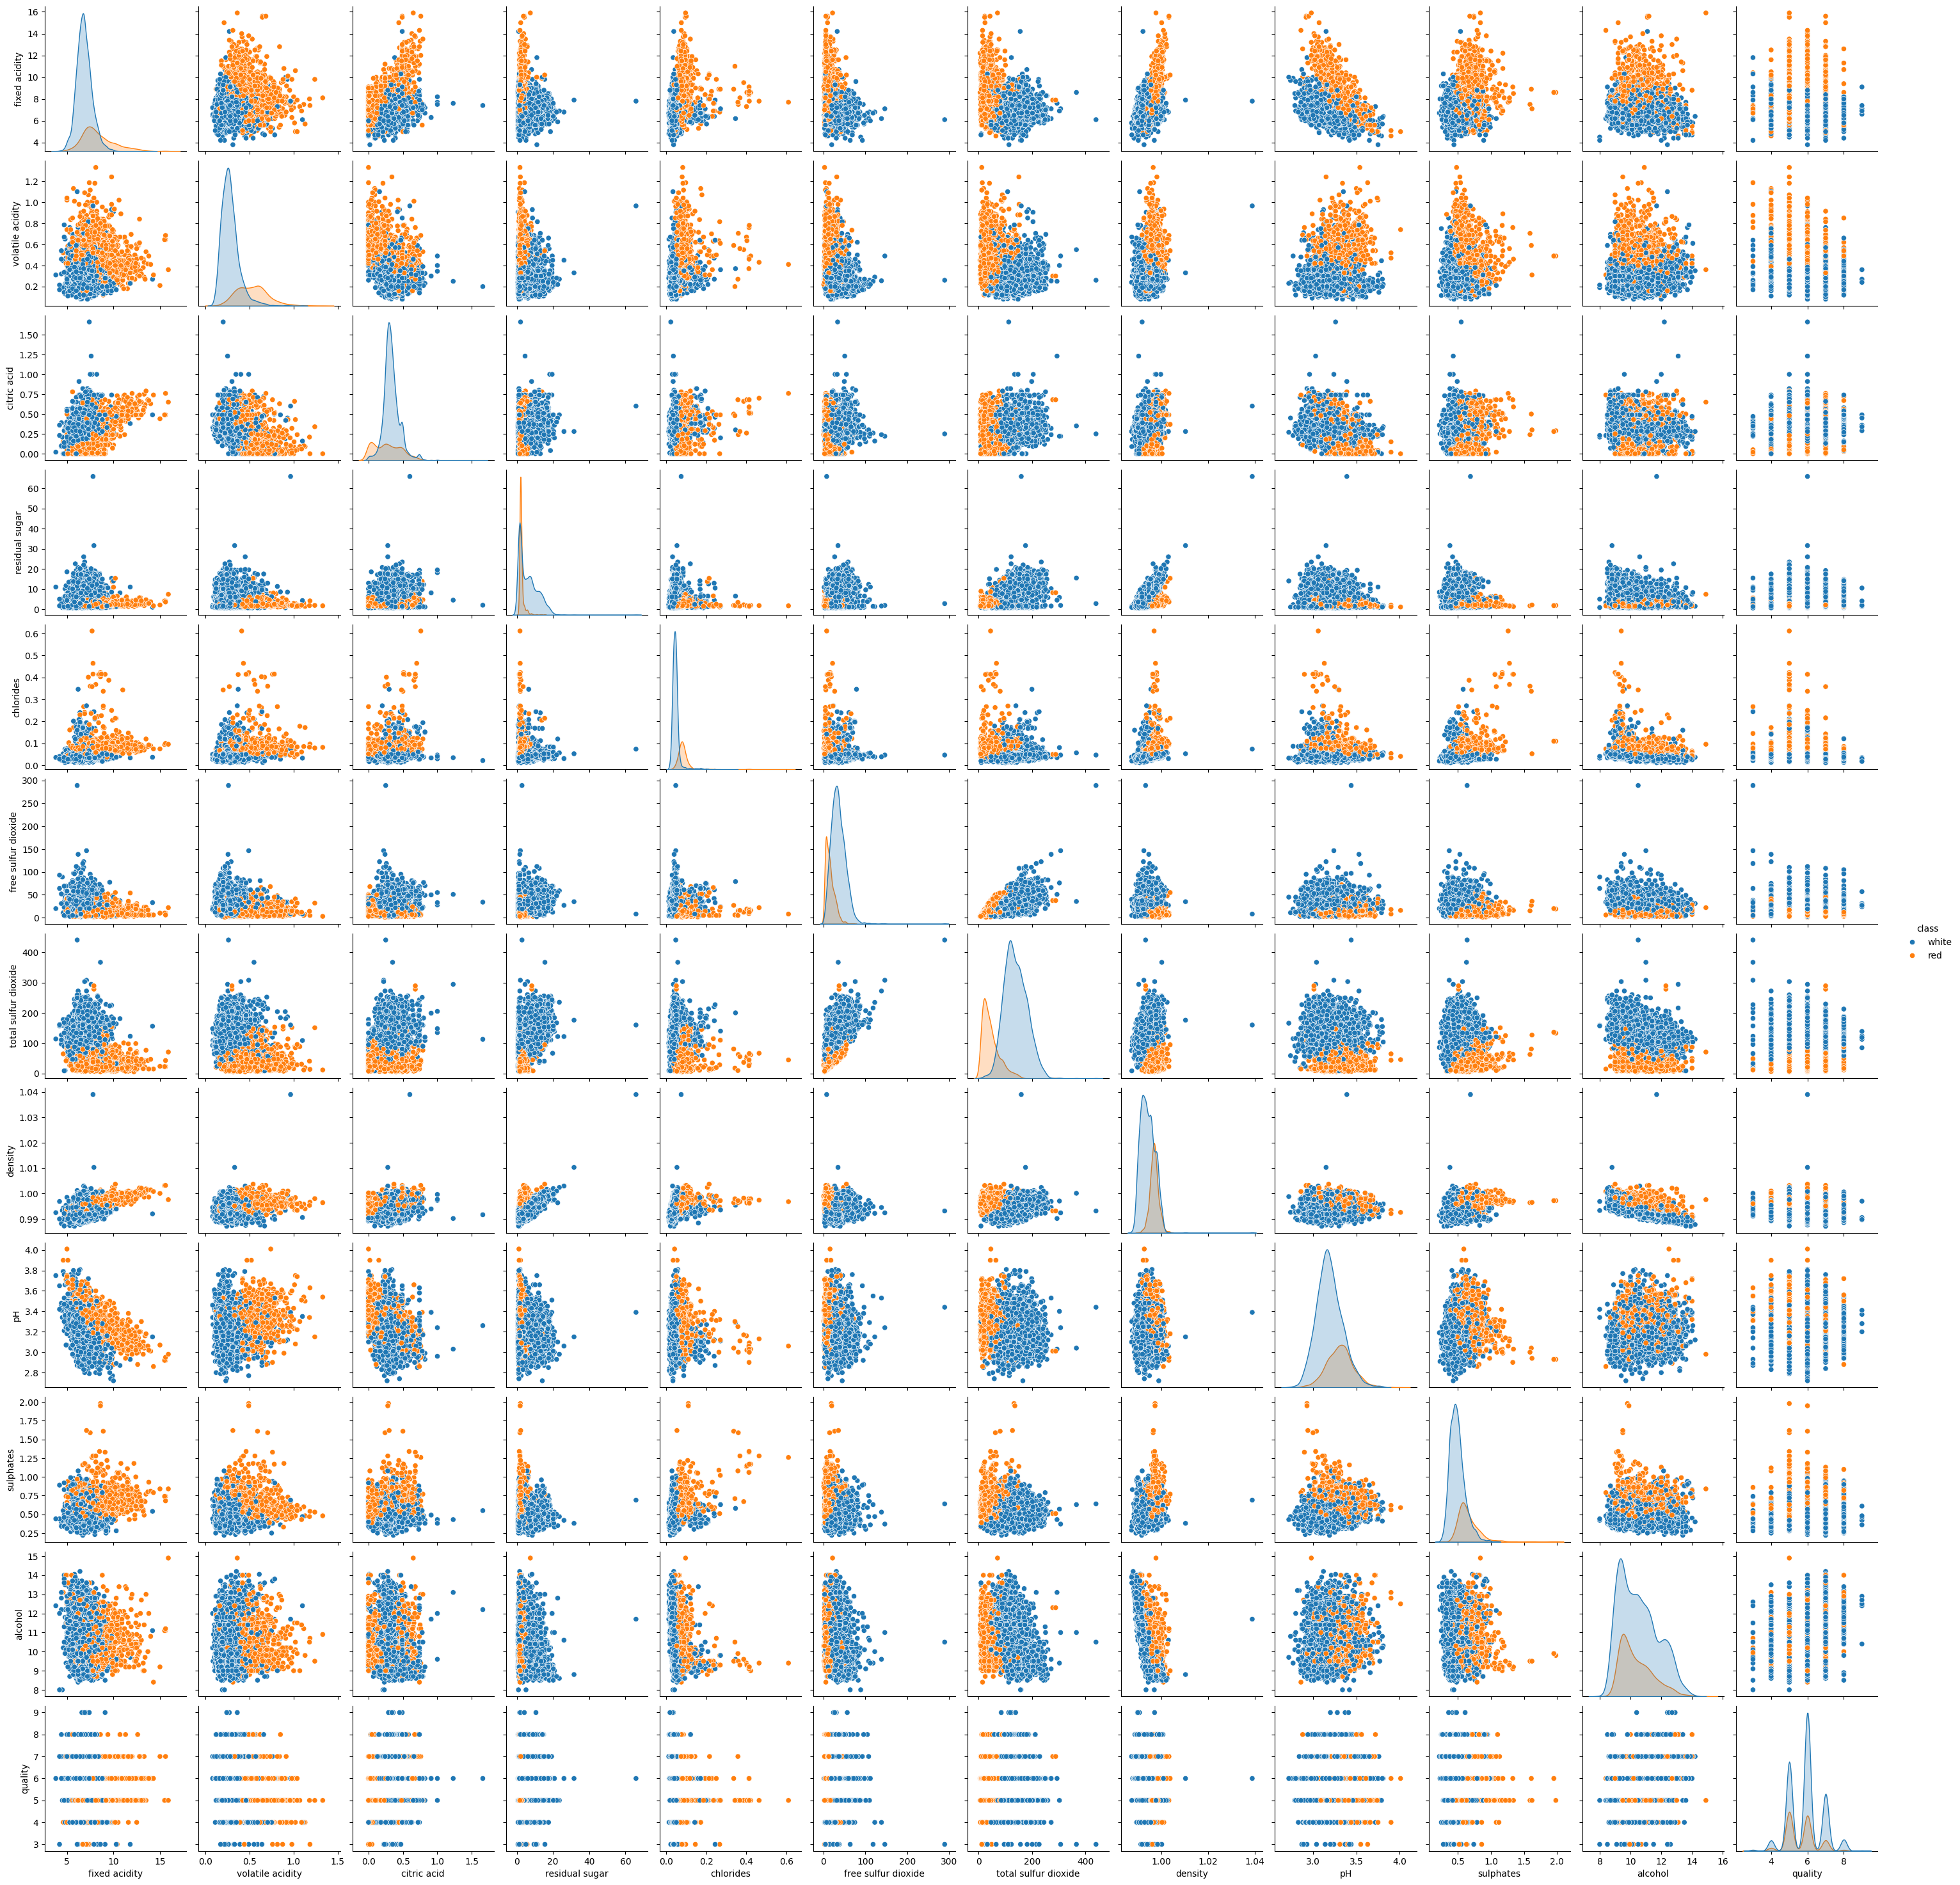

In [8]:
# Vamos a comprobar los valores que nos interesa tomar

sns.pairplot(X_train, hue = "class")

In [9]:
# Separamos en X_train e y_train

y_train = X_train[target]
X_train.drop(columns = 'class',inplace=True)


In [10]:
# Echamos un vistazo a X_train

X_train.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
3369            5.8              0.32         0.20             2.6      0.027   
1935            6.1              0.27         0.43             7.5      0.049   
4860            5.6              0.19         0.47             4.5      0.030   
1997            7.2              0.62         0.06             2.7      0.077   
3258            9.0              0.60         0.29             2.0      0.069   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
3369                 17.0                 123.0  0.98936  3.36       0.78   
1935                 65.0                 243.0  0.99570  3.12       0.47   
4860                 19.0                 112.0  0.99220  3.56       0.45   
1997                 15.0                  85.0  0.99746  3.51       0.54   
3258                 32.0                  73.0  0.99654  3.34       0.57   

      alcohol  quality  
3369     13.9        7  
1935      9.0        5  
4860     11.2        6  
1997      9.5        5  
3258     10.0        5

In [11]:
# Vamos a usar la matriz de correlación para ver relaciones entre las variables

corr = X_train.corr()
corr


fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000          0.227223     0.326898   
volatile acidity           0.227223          1.000000    -0.376146   
citric acid                0.326898         -0.376146     1.000000   
residual sugar            -0.113235         -0.188810     0.140242   
chlorides                  0.301847          0.384547     0.027609   
free sulfur dioxide       -0.288682         -0.354904     0.132501   
total sulfur dioxide      -0.336756         -0.415482     0.194010   
density                    0.461247          0.282606     0.090027   
pH                        -0.247550          0.256355    -0.326261   
sulphates                  0.301554          0.233009     0.054046   
alcohol                   -0.091290         -0.046531     0.008885   
quality                   -0.076988         -0.263880     0.089490   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity              -0.113235   0.301847            -0.288682   
volatile acidity           -0.188810   0.384547            -0.354904   
citric acid                 0.140242   0.027609             0.132501   
residual sugar              1.000000  -0.128639             0.392782   
chlorides                  -0.128639   1.000000            -0.192435   
free sulfur dioxide         0.392782  -0.192435             1.000000   
total sulfur dioxide        0.490264  -0.282529             0.724749   
density                     0.551213   0.364982             0.017183   
pH                         -0.266847   0.051126            -0.146299   
sulphates                  -0.177909   0.392800            -0.179747   
alcohol                    -0.354155  -0.261299            -0.182477   
quality                    -0.030606  -0.205684             0.051815   

                      total sulfur dioxide   density        pH  sulphates  \
fixed acidity                    -0.336756  0.461247 -0.247550   0.301554   
volatile acidity                 -0.415482  0.282606  0.256355   0.233009   
citric acid                       0.194010  0.090027 -0.326261   0.054046   
residual sugar                    0.490264  0.551213 -0.266847  -0.177909   
chlorides                        -0.282529  0.364982  0.051126   0.392800   
free sulfur dioxide               0.724749  0.017183 -0.146299  -0.179747   
total sulfur dioxide              1.000000  0.022563 -0.237456  -0.274047   
density                           0.022563  1.000000  0.015389   0.267280   
pH                               -0.237456  0.015389  1.000000   0.195063   
sulphates                        -0.274047  0.267280  0.195063   1.000000   
alcohol                          -0.259238 -0.683881  0.109032  -0.011328   
quality                          -0.038514 -0.311048  0.000702   0.034360   

                       alcohol   quality  
fixed acidity        -0.091290 -0.076988  
volatile acidity     -0.046531 -0.263880  
citric acid           0.008885  0.089490  
residual sugar       -0.354155 -0.030606  
chlorides            -0.261299 -0.205684  
free sulfur dioxide  -0.182477  0.051815  
total sulfur dioxide -0.259238 -0.038514  
density              -0.683881 -0.311048  
pH                    0.109032  0.000702  
sulphates            -0.011328  0.034360  
alcohol               1.000000  0.454296  
quality               0.454296  1.000000

<Axes: >

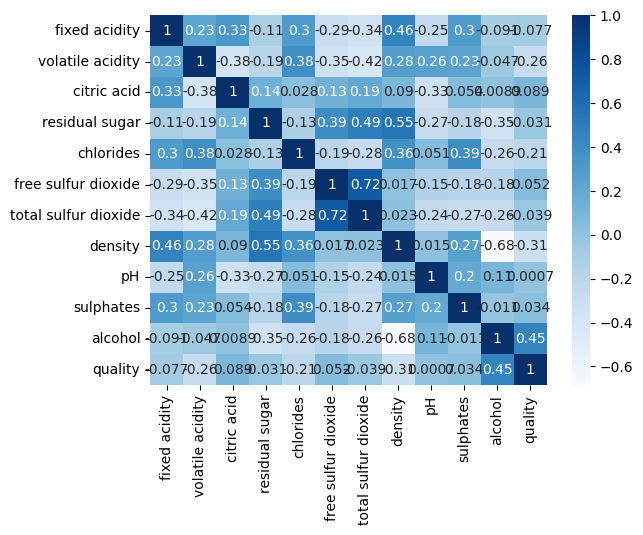

In [12]:
# Comprobamos matriz corr

sns.heatmap(corr, cmap="Blues", annot=True)

C:\Users\juanmanu.gomez\AppData\Local\Temp\ipykernel_27244\1163337128.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


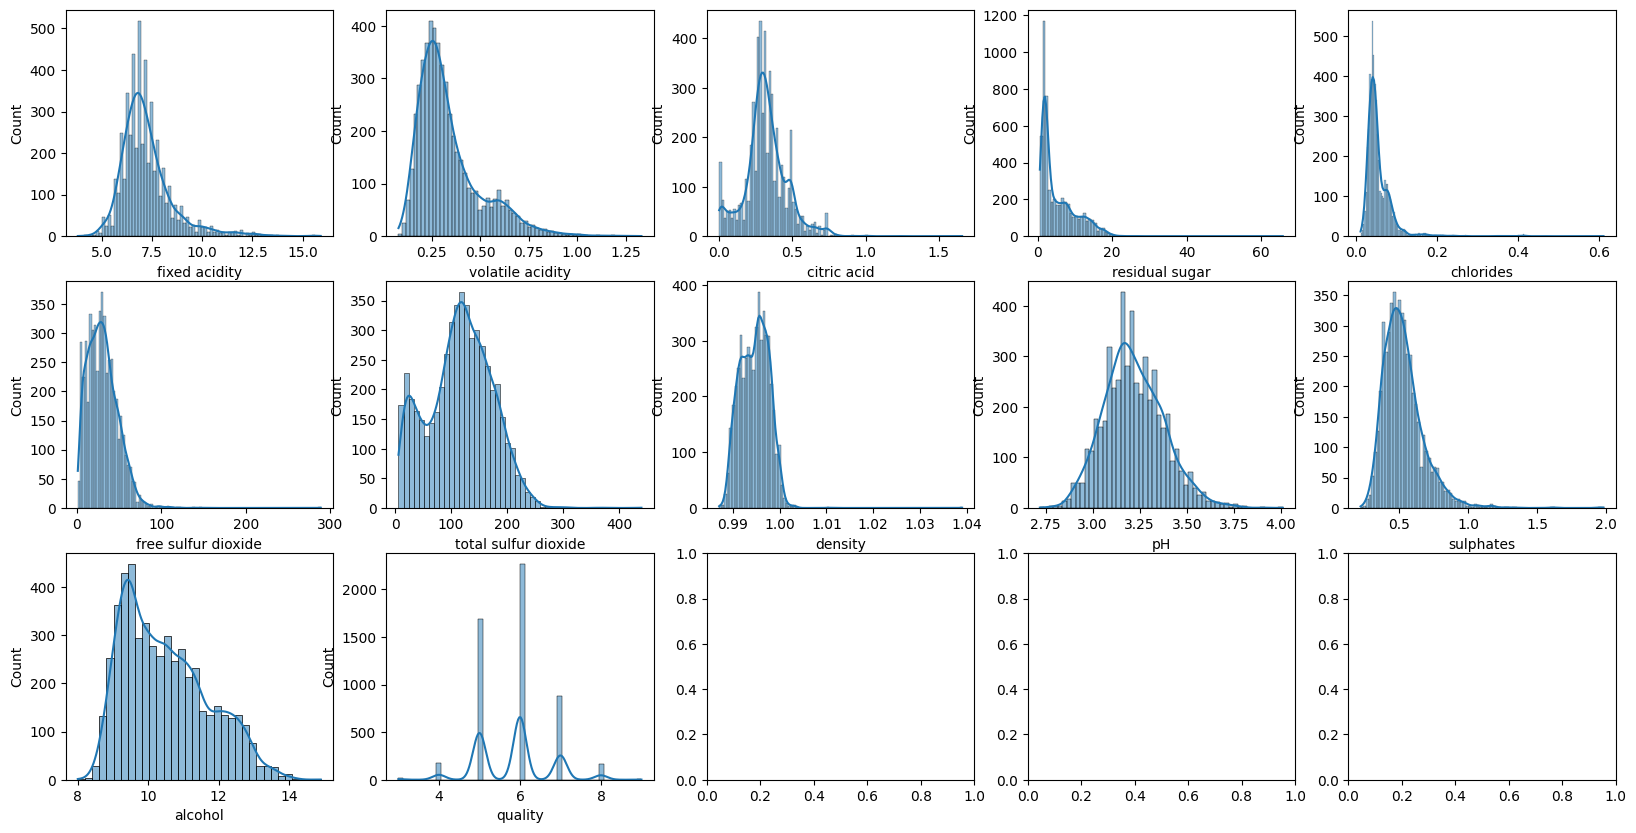

In [13]:
# Comprobamos que pinta tiene la distribución para aplicar una transformación logaritmica a las que sea necesario hacerlo.

columnas = len(X_train.columns)
filas = math.ceil(columnas/5)

fig,axes = plt.subplots(filas,5, figsize=(20,10))

columna = 0
fila = 0
for valor in X_train.columns:
    sns.histplot(X_train[valor],kde=True,ax=axes[fila,columna])
    columna += 1
    if columna == 5:
        columna = 0
        fila += 1
fig.show()

In [14]:
# Decidimos las columnas necesarias de las gráficas anteriores

''' Sobre las columnas a aplicar el logaritmo usaremos
- volatile acidity
- residual sugar
- chlorides
- free sulfur dioxide
- density
- sulphates
- alcohol

el resto tienenuna pinta más aceptable
'''
cambia_log = ['volatile acidity','residual sugar','chlorides','free sulfur dioxide','density','sulphates','alcohol']

In [15]:
# Ajustamos las categorías del target para poder calcular con ellas y los modelos

condicion = y_train =='red'
y_train.loc[condicion] = 0

condicion = y_train =='white'
y_train.loc[condicion] = 1

y_train = y_train.astype(float)


C:\Users\juanmanu.gomez\AppData\Local\Temp\ipykernel_27244\3647643931.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.loc[condicion] = 0
C:\Users\juanmanu.gomez\AppData\Local\Temp\ipykernel_27244\3647643931.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.loc[condicion] = 1


In [16]:
#Creamos el pipeline 

columns_to_exclude=['total sulfur dioxide']
columnas = list(X_train.columns)
columnas.remove('total sulfur dioxide')

# Escalado de valores numéricas
num_pipeline = Pipeline(
    [
     ("Logaritmo",FunctionTransformer(func = np.tanh)),
     ("SScaler", StandardScaler())
    ]
)

# Preprocesado completo
preprocessing = ColumnTransformer(
    [
     ("Process Numeric", num_pipeline, columnas),
     ("Exclude", "drop", columns_to_exclude)
    ], remainder = "passthrough")

# Modelos a utilizar
logistic_pipeline = Pipeline(
    [("Preprocesado", preprocessing),
     ("Modelo", LogisticRegression())
    ])

random_pipeline = Pipeline(
    [("Preprocesado", preprocessing),
     ("Modelo", RandomForestClassifier())
    ])

xgb_pipeline = Pipeline(
    [("Preprocesado", preprocessing),
     ("Modelo", XGBClassifier())
    ])



In [17]:
# Aplicamos los gridsearch sobre los modelos

pipe_reg_log_param = {    
                 "Modelo__penalty": [None,"l2"], 
                 "Modelo__C": np.logspace(0, 4, 10)
                }

pipe_rand_forest_param = {
    'Modelo__n_estimators': [10, 100, 200, 400],
    'Modelo__max_depth': [1,2,4,8],
    'Modelo__max_features': [1, 2, 3]
    }

pipe_xgb_param = {
    'Modelo__n_estimators': [10, 100, 200, 400],
    'Modelo__max_depth': [1,2,4,8],
    'Modelo__learning_rate': [0.1,0.2,0.5,1.0]
}

cv = 5

gs_reg_log = GridSearchCV(logistic_pipeline,
                            pipe_reg_log_param,
                            cv=cv,
                            scoring="accuracy",
                            verbose=1,
                            n_jobs=-1)

gs_rand_forest = GridSearchCV(random_pipeline,
                            pipe_rand_forest_param,
                            cv=cv,
                            scoring="accuracy",
                            verbose=1,
                            n_jobs=-1)

gs_xgb = GridSearchCV(xgb_pipeline,
                        pipe_xgb_param,
                        cv=cv,
                        scoring="accuracy",
                        verbose=1,
                        n_jobs=-1)

pipe_grids = {"gs_reg_log":gs_reg_log,
         "gs_rand_forest":gs_rand_forest,
         "gs_xgb":gs_xgb}
    


In [18]:
# Iteramos para encontrar el mejor modelo

for nombre, grid_search in pipe_grids.items():
    grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [19]:
# Vamos a coger los mejores resultados de cada modelo

best_grids = [(i, j.best_score_) for i, j in pipe_grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

Grid  Best score
2          gs_xgb    0.991341
1  gs_rand_forest    0.989609
0      gs_reg_log    0.952280

In [20]:
# Nos quedamos con el mejor

best_model = pipe_grids[best_grids.iloc[0,0]]

In [21]:
# Muestro el mejor modelo

best_model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Process '
                                                                         'Numeric',
                                                                         Pipeline(steps=[('Logaritmo',
                                                                                          FunctionTransformer(func=<ufunc 'tanh'>)),
                                                                                         ('SScaler',
                                                                                          StandardScaler())]),
                                                                         ['fixed '
                                                                          'acidity',
                                                                          'volatile '
                                                                          'acidity',
                                                                          'citric '
                                                                          'acid',
                                                                          'residual '
                                                                          'sugar',
                                                                          'chlorides',
                                                                          'free '
                                                                          'sulfur '
                                                                          'dioxide',
                                                                          'densi...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'Modelo__learning_rate': [0.1, 0.2, 0.5, 1.0],
                         'Modelo__max_depth': [1, 2, 4, 8],
                         'Modelo__n_estimators': [10, 100, 200, 400]},
             scoring='accuracy', verbose=1)

In [22]:
# Vamos a ver como clasifica el X_test e y_test

# Vamos a cambiar los valores del y_test para la prediccion
# Ajustamos las categorías del target
y_test = X_test[target]

condicion = y_test =='red'
y_test.loc[condicion] = 0

condicion = y_test =='white'
y_test.loc[condicion] = 1

y_test = y_test.astype(float)

C:\Users\juanmanu.gomez\AppData\Local\Temp\ipykernel_27244\2289254232.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[condicion] = 0
C:\Users\juanmanu.gomez\AppData\Local\Temp\ipykernel_27244\2289254232.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[condicion] = 1


In [23]:
# Aplicamos el modelo al X_test entrenado ya para predecir mis valores

y_pred = gs_xgb.predict(X_test)

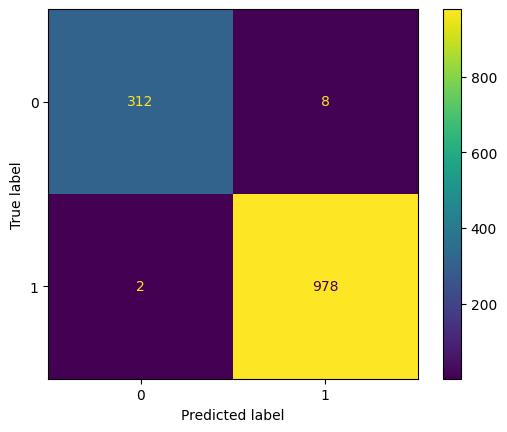

In [24]:
# Finalmente aplicamos la matriz de confusion para ver mis resultados

conf = confusion_matrix(y_test,y_pred)
confusion_mat = ConfusionMatrixDisplay(confusion_matrix=conf)
confusion_mat.plot()